In [1]:
import numpy as np
import os
import sys
import argparse
import collections

sys.path.append('../posterior_prob/')

In [2]:
import precision_recall_scores as prs
import iotools
import get_plotvals

import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import linear_model

In [31]:
def add_vert_insets(fig, ax, hfrac, vfrac, hoffset, voffset, ratios):

    bbox = ax.get_position()
    axleft = bbox.x0
    axwidth = bbox.width
    axbottom = bbox.y0
    axheight = bbox.height

    iax_left   = axleft   + hoffset * axwidth
    iax_bottom = axbottom + voffset * axheight
    iax_width  = hfrac * axwidth
    iax_height = [(vfrac / sum(ratios)) * x * axheight for x in ratios]

    iax = [None for x in ratios]
    for i, x in enumerate(ratios):
        iax[i] = fig.add_axes([iax_left, iax_bottom, iax_width, iax_height[i]])
        iax_bottom += iax_height[i]
    
    return iax

def visual_aid(data, xvals, nbins = 10):  
    bins = np.percentile(data, np.linspace(0, 100, nbins + 1))
    binidx = np.digitize(data, bins)
    x = np.zeros(nbins)
    y = np.zeros(nbins)
    for i in range(nbins):
        xsplit = xvals[np.where(binidx == i + 1)]
        ysplit = data[np.where(binidx == i + 1)]
        x[i] = np.median(xsplit)
        y[i] = np.median(ysplit)
    return x, y

def insetplot(iax, df, bordercolor, borderwidth, label_font_size, axis_font_size):
    
    nsample = df.shape[0]
    xvals   = np.array(df['xval'])
    logprob = np.array(df['logistic_prob'])
    linpred = np.array(df['linear_pred'])
    
    case_xvals   = df[df['pheno'] == 1]['xval']
    ctrl_xvals   = df[df['pheno'] == 0]['xval']
    case_logprob = df[df['pheno'] == 1]['logistic_prob']
    ctrl_logprob = df[df['pheno'] == 0]['logistic_prob']
    case_linpred = df[df['pheno'] == 1]['linear_pred']
    ctrl_linpred = df[df['pheno'] == 0]['linear_pred']


    bins = np.linspace(np.min(xvals), np.max(xvals), 21)
    ncase, _ = np.histogram(case_xvals, bins = bins)
    nctrl, _ = np.histogram(ctrl_xvals, bins = bins)
    ncase = ncase / nsample
    nctrl = nctrl / nsample
    
    colors = ['#C10020', '#FF6800', '#007D34', '#93AA00', ]

    # Plot the histograms in iax[0] and iax[2]
    x = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    xnew = np.linspace(x[0], x[-1], 101) # for a smooth plot
    
    f2 = interp1d(x, nctrl, kind='cubic')
    iax[0].plot(xnew, -f2(xnew), color=bordercolor, lw=borderwidth, zorder=10) # plotting inverted distribution
    iax[0].fill_between(xnew, -f2(xnew), 0, color=bordercolor, alpha=0.1, zorder=5)
    ctrlmax = max(f2(xnew))

    f2 = interp1d(x, ncase, kind='cubic')
    iax[2].plot(xnew,  f2(xnew), color=bordercolor, lw=borderwidth, zorder=10)
    iax[2].fill_between(xnew, f2(xnew), 0, color=bordercolor, alpha=0.1, zorder=5)
    casemax = max(f2(xnew))
    
    ymax = max(ctrlmax, casemax) * 1.1
    iax[0].set_ylim(-ymax, 0)
    iax[2].set_ylim(0, ymax)
    for ax in [iax[0], iax[2]]:
        ax.axis('off')

        
    # Plot the scatterplots and visual aids
    case_idx = np.random.choice(case_xvals.shape[0], int(case_xvals.shape[0] / 5), replace=False)
    ctrl_idx = np.random.choice(ctrl_xvals.shape[0], int(ctrl_xvals.shape[0] / 5), replace=False)
    iax[1].scatter(case_xvals[case_idx], case_logprob[case_idx], alpha=0.4, s=1, color=colors[0], zorder=30)
    iax[1].scatter(ctrl_xvals[ctrl_idx], ctrl_logprob[ctrl_idx], alpha=0.4, s=1, color=colors[1], zorder=30)
    iax[1].scatter(case_xvals[case_idx], case_linpred[case_idx], alpha=0.4, s=1, color=colors[2], zorder=20)
    iax[1].scatter(ctrl_xvals[ctrl_idx], ctrl_linpred[ctrl_idx], alpha=0.4, s=1, color=colors[3], zorder=20)
    x, y = visual_aid(logprob, xvals, nbins = 10)
    iax[1].plot(x, y, lw = 3, color= bordercolor, dashes = [5, 4], zorder=40)
    x, y = visual_aid(linpred, xvals, nbins = 10)
    iax[1].plot(x, y, lw = 3, color= bordercolor, dashes = [5, 4], zorder=40)
    
    iax[1].set_ylim(-0.2, 1.2)
    iax[1].set_yticks([0.0, 0.5, 1.0])
    iax[1].set_xticks([])
    iax[1].tick_params(axis='both', which = 'major',
                       length = 4, width = borderwidth, pad=5,
                       direction = 'out',
                       color = bordercolor,
                       labelcolor = bordercolor,
                       bottom = False, top = False, left = True, right = False
                       )
    font_properties = {'family':'sans-serif', 'weight': 'normal', 'size': label_font_size}
    iax[1].set_xticklabels(iax[1].get_xticks(), font_properties)
    iax[1].set_yticklabels(iax[1].get_yticks(), font_properties)
    
    for side, border in iax[1].spines.items():
        border.set_linewidth(borderwidth)
        border.set_color(bordercolor)

    xmin = np.percentile(xvals, 1)
    xmax = np.percentile(xvals, 99)
    for ax in iax:
        ax.set_xlim(xmin, xmax)
        
    mylabel = r"$\boldsymbol{y_{\text{pred}}}$" + " or\n" + r"$\boldsymbol{p(\phi = 1)}$"
    mxlabel = r'$\boldsymbol{\sum_i x_i \beta_i}$'
    iax[1].set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 15)

    xlabel = iax[1].xaxis.get_label()
    xlab_xpos, xlab_ypos = xlabel.get_position()
    xlabel.set_position([1.0, xlab_ypos])
    xlabel.set_horizontalalignment('right')
    iax[1].set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 15)
        
    return

In [5]:
def coreplot(ax, xvals, yvals, ystd, color, myls, mlabel, mzorder):
    yupper = np.minimum(yvals + ystd, 1)
    ylower = yvals - ystd
    color = color
    linestyle = myls

    coef = 12
    _dash = 1
    _dot = 0.3
    _dashspace = 0.8
    _dotspace = 0.5
    mydash = []
    if myls == 'solid':
        mydash = []
    elif myls == 'dashed':
        mydash = [_dash, _dashspace]
    elif myls == 'dotted':
        mydash = [_dot, _dotspace]
    elif myls == 'dashdot':
        mydash = [_dash, _dashspace, _dot, _dashspace]
    elif myls == 'dashdotdot':
        mydash = [_dash, _dashspace, _dot, _dashspace, _dot, _dashspace]
    elif myls == 'dashdashdot':
        mydash = [_dash, _dashspace, _dashspace, _dashspace, _dot, _dashspace]
    mydash = [x * coef for x in mydash]

    ax.plot(xvals, yvals, color=color, dashes = mydash, lw=4, label=mlabel, zorder=mzorder)
    return

def show_prcplot(filename, data, phenodf, xlim, ylim, xticks, yticks):
    ''' Use the same plot params for different benchmarks.
    '''

    kelly_colors_hex = [
        '#FFB300', # Vivid Yellow
        '#803E75', # Strong Purple
        '#FF6800', # Vivid Orange
        '#A6BDD7', # Very Light Blue
        '#C10020', # Vivid Red
        '#CEA262', # Grayish Yellow
        '#817066', # Medium Gray

        # The following don't work well for people with defective color vision
        '#007D34', # Vivid Green
        '#F6768E', # Strong Purplish Pink
        '#00538A', # Strong Blue
        '#FF7A5C', # Strong Yellowish Pink
        '#53377A', # Strong Violet
        '#FF8E00', # Vivid Orange Yellow
        '#B32851', # Strong Purplish Red
        '#F4C800', # Vivid Greenish Yellow
        '#7F180D', # Strong Reddish Brown
        '#93AA00', # Vivid Yellowish Green
        '#593315', # Deep Yellowish Brown
        '#F13A13', # Vivid Reddish Orange
        '#232C16', # Dark Olive Green
        ]
    
    rowell_colors_hex = [
        '#2D69C4', # blue 
        '#DA7C30', # yellowish orange
        '#3E9651', # green
        '#CC2529', # red
        '#535154', # gray
        '#6B4C9A', # purple
        '#922428', # dark brown
        '#948B3D', # olive
        ]
    
    banskt_colors_hex = [
        '#2D69C4', # blue 
        '#FFB300', # Vivid Yellow
        '#93AA00', # Vivid Yellowish Green
        '#CC2529', # red
        '#535154', # gray
        '#6B4C9A', # purple
        '#922428', # dark brown
        '#948B3D', # olive
        ]

    bordercolor = '#333333'
    borderwidth = 2
    colors = banskt_colors_hex
    figsize = (13, 12)
    axis_font_size = 30
    label_font_size = 25
    legend_font_size = 25


    fig = plt.figure(figsize = figsize)
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    mlabels = {'blore':   'B-LORE',
               'probit':  'BVSR probit',
               'linear':  'BVSR linear',
               'finemap': 'FINEMAP',
               'jam':     'JAM',
               'bimbam':  'BIMBAM',
               'snptest': 'Single SNP',
              }

    mcolors = {'blore':   colors[3],
               'probit':  colors[0],
               'linear':  colors[1],
               'finemap': colors[2],
               'jam':     colors[6],
               'bimbam':  colors[5],
               'snptest': colors[4],
              }
    
    mzorder = {'blore':   100,
               'probit':  50,
               'linear':  40,
               'finemap': 30,
               'jam':     10,
               'bimbam':  20,
               'snptest': 60,
              }

    for key in ['blore', 'probit', 'linear', 'finemap', 'jam', 'bimbam', 'snptest']:
        val = data[key]
        if not val == 0:
            if len(val[0]) > 0:
                x = val[0]
                y = val[2]
                err = val[4]
                coreplot(ax1, x, y, err, mcolors[key], 'solid', mlabels[key], mzorder[key])
                y = val[1]
                err = val[3]
                coreplot(ax2, x, y, err, mcolors[key], 'dashed', None, mzorder[key])

    mxlabel = r'Top ranked SNPs'
    my1label = r'Recall'
    my2label = r'Precision'

    font_properties = {'family':'sans-serif', 'weight': 'bold', 'size': axis_font_size, 'color':bordercolor}
    ax1.set_xlabel(mxlabel, font_properties, labelpad = 15)
    ax1.set_ylabel(my1label, font_properties, labelpad = 20)
    ax2.set_ylabel(my2label, font_properties, labelpad = 20)
    
    for ax in [ax1, ax2]:
        
        if xlim is not None: ax.set_xlim(xlim)
        if ylim is not None: ax.set_ylim(ylim)
        if xticks is not None: ax.set_xticks(xticks)
        if yticks is not None: ax.set_yticks(yticks)

        h, l = ax.get_legend_handles_labels()
        if len(l) > 0:
            legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                               handlelength = 3.0,
                               handletextpad = 2.0,
                               markerscale=5,
                               ncol = 1,
                               frameon = True, borderpad = 1.5, labelspacing = 1.5
                               #title = legendtitle
                              )
            for l in legend.legendHandles:
                l.set_alpha(1)
            lframe = legend.get_frame()
            lframe.set_edgecolor(bordercolor)
            lframe.set_linewidth(borderwidth)
            for fonts in ([legend.get_title()] + legend.texts):
                fonts.set_fontsize(legend_font_size)
                fonts.set_color(bordercolor)

        ax.tick_params(axis='both', which = 'major',
                       length = 10, width = borderwidth, pad=10,
                       color = bordercolor,
                       labelcolor = bordercolor,
                       bottom = True, top = False, left = True, right = True
                      )
        font_properties = {'family':'sans-serif', 'weight': 'bold', 'size': label_font_size}
        xticks = ax.get_xticks()
        yticks = ax.get_yticks()
        xticklabels = ['{:g}'.format(x) for x in xticks]
        yticklabels = ['{:3.1f}'.format(x) for x in yticks]
        ax.set_xticklabels(xticklabels, font_properties)
        ax.set_yticklabels(yticklabels, font_properties)
        
        for side, border in ax.spines.items():
            border.set_linewidth(borderwidth)
            border.set_color(bordercolor)
        ax.grid(color='dimgray', lw=0.5, alpha=0.5)

    plt.tight_layout()
    iax = add_vert_insets(fig, ax1, 0.4, 0.4, 0.55, 0.07, [1, 3, 1])
    insetplot(iax, phenodf, bordercolor, borderwidth, label_font_size, axis_font_size)  
    #plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    return

In [6]:
locusfile = os.path.abspath('/scratch/sbanerj/quasi_laplace_gwas/LOCUSNAMES.MAXSNPS')
basedir = os.path.abspath('/scratch/sbanerj/quasi_laplace_gwas/simulations')
whichplot = ['blore', 'finemap', 'linear', 'probit', 'snptest']
startsim = 61
endsim = 62
cmax = 2
use_credible = True

locusprefixes = iotools.read_locusprefixes(locusfile)

res = collections.defaultdict(lambda:0)
for key in whichplot:
    res[key] = list()

for sim in range(startsim, endsim + 1):
    simname = 'sim{:03d}'.format(sim)
    print ('Reading {:s}'.format(simname))
    simdir = os.path.join( basedir, simname)
    causal_snps_file = os.path.join(simdir, 'samples', 'causal.snplist')
    causal_rsids = iotools.read_causal_rsids(causal_snps_file)
    for key in whichplot:
        thisres = iotools.read_simres(simdir, key, locusprefixes, causal_rsids, cmax, '0')
        res[key].append(thisres)

nmax = 0
plotvals = collections.defaultdict(lambda:0)
for key in whichplot:
    if use_credible:
        data = list()
        for x in res[key]:
            data += x
    else:
        data = [[y for z in x for y in z] for x in res[key]]
    maxlen = max([len(x) for x in data])
    if maxlen > nmax:
        nmax = maxlen
    plotvals[key] = get_plotvals.precision_recall_threshold(data)

Reading sim061
Reading sim062


In [7]:
study = 'combined'
simname = 'sim{:03d}'.format(startsim)
simdir = os.path.join(basedir, simname)
lnfile = os.path.join(basedir, 'LOCUSNAMES.MAXSNPS')
phenofile = os.path.join(simdir, 'samples/{:s}/phenotypes.sample'.format(study))


colnames = ['dum', 'missing', 'father', 'mother', 'sex', 'age', 'pheno']
dropnames = ['dum', 'missing', 'father', 'mother']
phenodf = pd.read_csv(phenofile, delimiter=' ', names = colnames, header=None, skiprows=2, index_col=0)
phenodf.drop(dropnames, inplace=True, axis=1)

snplistfile = os.path.join(simdir, 'samples/{:s}/snps.effectsize'.format('G1'))
colnames = ['beta']
betadf = pd.read_csv(snplistfile, header=None, names=colnames, delimiter = '\t', index_col=0)
betadf.index = [x.strip() for x in betadf.index.tolist()]

colnames = ['ref', 'alt'] + phenodf.index.tolist()
for l, locusprefix in enumerate(locusprefixes):
    dosagefile = os.path.join(basedir, '..', 'loci_dosages', '{:s}/{:s}.matgen'.format(study, locusprefix))
    dosage = pd.read_csv(dosagefile, header=None, names=colnames, delimiter=',', index_col=0)
    common_snps = [x for x in dosage.index.tolist() if x in betadf.index.tolist()]
    locusgt = dosage.loc[common_snps].drop(['ref', 'alt'], axis=1)
    if l == 0:
        gt = locusgt
    else:
        gt = gt.append(locusgt)

In [8]:
#colnames = ['dum', 'missing', 'father', 'mother', 'sex', 'age', 'pheno']
#dropnames = ['dum', 'missing', 'father', 'mother']
#phenodf = pd.read_csv(phenofile, delimiter=' ', names = colnames, header=None, skiprows=2, index_col=0)
#phenodf.drop(dropnames, inplace=True, axis=1)
mbeta = betadf.loc[gt.index.tolist()]
phenodf['xval'] = np.dot(np.array(gt).T, (np.array(mbeta)))

clf = linear_model.LogisticRegression(C=1e5)
X = np.array(gt).T
y = np.array(phenodf['pheno'])
if phenodf['pheno'].isnull().any():
    ivalid = np.where(~np.isnan(y))[0]
    X = X[ivalid, :]
    y = y[ivalid]
clf.fit(X, y)

ols = linear_model.LinearRegression()
ols.fit(X, y)

phenodf = phenodf.dropna(axis=0)
phenodf['logistic_prob'] = clf.predict_proba(X)[:, 1]
phenodf['linear_pred'] = ols.predict(X)

#outfile = os.path.join(basedir, simdir, 'logistic_data_{:s}.txt'.format(study))
#phenodf.to_csv(outfile)

Yticks: [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8]
Yticks: [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8]


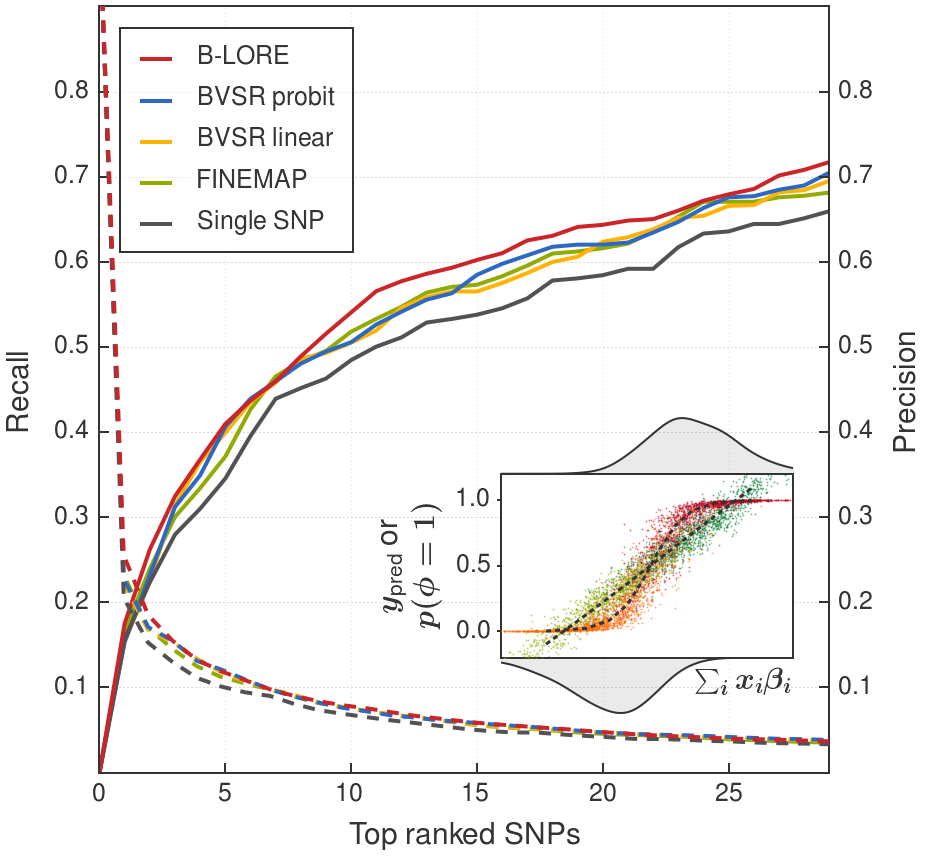

In [32]:
xlim = [0, int(0.15 * nmax)]
ylim = [0, 0.9]
xticks = None
yticks = np.arange(0.1, 0.9, 0.1)

outfile = 'tmp.pdf'

show_prcplot(outfile, plotvals, phenodf, xlim, ylim, xticks, yticks)